# Working with real data

Until this point we have worked with synthetic data, it was good but everything good in life comes to an end so now we'll be using real data with real problems.

We'll be using [nmrglue](https://nmrglue.readthedocs.io/en/latest/tutorial.html) for loading our data into the notebook. This library also has many processing functions similar to the ones we developed before. 

### Import libraries

In [1]:
# import libraries
import os
import os.path as op

import numpy as np
from bokeh.io import output_notebook, reset_output, show
from bokeh.plotting import figure

# import from our own local module
from procnmr.plotting import bkplot
import nmrglue as ng

In [2]:
reset_output()
output_notebook()

Loading BokehJS ...

In [3]:
datadir = 'data/lurasidona'

In [4]:
par, fid = ng.bruker.read(op.join(datadir, '1'))

In [5]:
fid.shape

(32768,)

In [6]:
fig_fid = bkplot(x=range(fid.shape[-1]), y=fid.real)

In [7]:
show(fig_fid)

In [9]:
ft = ng.proc_base.fft(fid)

In [10]:
fig_ft = bkplot(x=range(ft.shape[-1]), y=ft.real)
show(fig_ft)

This looks really ugly, we have to remove Bruker's digital filter. Fortunately `nmrglue` has a function for that.

In [11]:
fid2 = ng.bruker.remove_digital_filter(par, fid)

In [12]:
ft2 = ng.proc_base.fft(fid2)

In [13]:
fig_ft2 = bkplot(x=range(ft2.shape[-1]), y=ft2.real)
show(fig_ft2)

In [14]:
def phase_corr(data, p0, p1) :
    p0 = p0 * np.pi / 180. 
    p1 = p1 * np.pi / 180.
    size = data.shape[-1]
    corr = np.exp(-1.0j * (p0 + (p1 * np.linspace(0, 1, size)))).astype(data.dtype)
    return corr * data

In [15]:
par.keys()

dict_keys(['procs', 'acqus', 'pprog', 'FILE_SIZE'])

In [16]:
ph0 = par['procs']['PHC0']
ph1 = par['procs']['PHC1']

In [17]:
ph0, ph1

(164.418, -2.453879)

In [18]:
p0 = ph0
p1 = ph1

ft3 = phase_corr(ft2, p0, p1)

fig_ft3 = bkplot(x=range(ft3.shape[-1]), y=ft3.real)
show(fig_ft3)

## Mapping the spectral phase space
We would like to visualize the dependence of the spectrum with respect to both zero and first order phase. We already have defined a formula for the dependence of the spectrum with respect to each phase. What we need is an objective function that represents the goodnes of a spectrum. A lot has been written about this topic, what we'd like to achieve is to maximize the absorptive portion of the spectra while minimizing the dispersive part. One objective function we could use is the total negative integral, which is minimal when the spectrum is in full absorptive mode. 

In [22]:
def tot_neg_int(data) :
    ''' returns total positive integral '''
    return sum([x for x in data.real if x < 0])

In [29]:
# create matrix of total positive integral on zero and first order phase
p0_points = 72
p1_points = 72
ph0_max = 360
ph1_max = 360

objf = np.zeros((p0_points,p1_points))
for p0 in range(p0_points):
    for p1 in range(p1_points):
        ph0 = p0*ph0_max/p0_points
        ph1 = p1*ph1_max/p1_points
        f = phase_corr(ft2, ph0, ph1)
        objf[p0,p1] = abs(tot_neg_int(f))

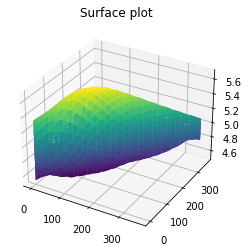

In [30]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

x = np.linspace(0, ph0_max, p0_points)
y = np.linspace(0, ph1_max, p1_points)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, objf,cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
plt.show()

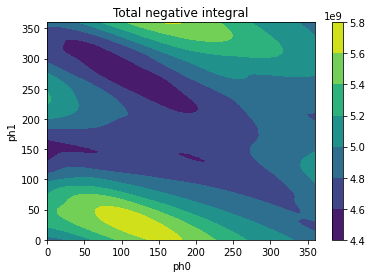

In [31]:
X, Y = np.meshgrid(x, y)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, objf)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Total negative integral')
ax.set_xlabel('ph0')
ax.set_ylabel('ph1')
plt.show()

In [32]:
p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")])
p.x_range.range_padding = p.y_range.range_padding = 0

# must give a vector of image data for image parameter
p.image(image=[objf], x=0, y=0, dw=360, dh=360, palette="Spectral11", level="image")
p.grid.grid_line_width = 0.5

#output_file("image.html", title="image.py example")

show(p)

go [next](05_phasing_pro.ipynb) or go [home](00_introduction.ipynb), there's no going [back](03_basic_processing.ipynb)